IMPORTING LIBRARIES

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

from IPython.display import HTML, display

from typing import Tuple

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_theme()


LOADING THE DATASET

In [9]:
df=pd.read_csv('pdspeech.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [11]:
Column_names=list(df.columns)

In [12]:
df.isna().sum()

id                           0
gender                       0
PPE                          0
DFA                          0
RPDE                         0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 755, dtype: int64

CLASS IMBALANCE


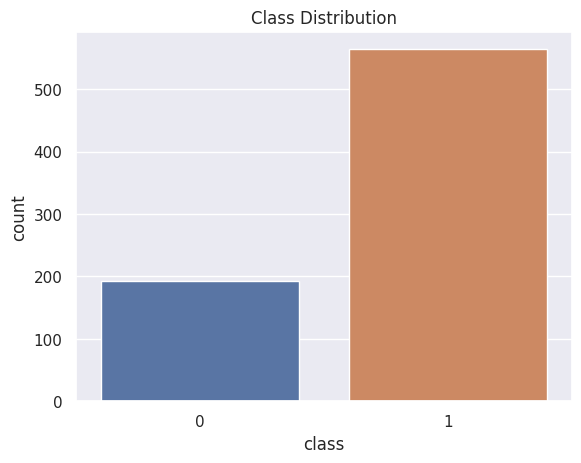

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='class')
plt.title("Class Distribution")
plt.show()

FOR HANDLING OUTLIERS

In [14]:
def Manual(data, numeric_columns=None, outlier_factor=1.5, keep_outliers=False):
    data_copy = data.copy()

    if numeric_columns is None:
        numeric_columns = data_copy.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = data_copy[col].quantile(0.25)
        Q3 = data_copy[col].quantile(0.75)
        IQR = Q3 - Q1


        lower_bound = Q1 - outlier_factor * IQR
        upper_bound = Q3 + outlier_factor * IQR

        if keep_outliers:
            data_copy = data_copy[(data_copy[col] < lower_bound) | (data_copy[col] > upper_bound)]
        else:
            data_copy = data_copy[(data_copy[col] >= lower_bound) & (data_copy[col] <= upper_bound)]

    return data_copy

PERFORMING RANDOM OVER SAMPLER FOR CLASS IMBALANCE

In [15]:
data = Manual(df)
data = data.reset_index(drop=True)

X=df.iloc[:, :-1]
y=df.iloc[:, -1]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

#for feature selection
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
X = selector.transform(X)

#for class imbalance
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=69)
X_Data, Y_Lavel = ros.fit_resample(X, y)

n_splits = 30

PAIR PLOT OF KDE AND CORRELATION VALUES

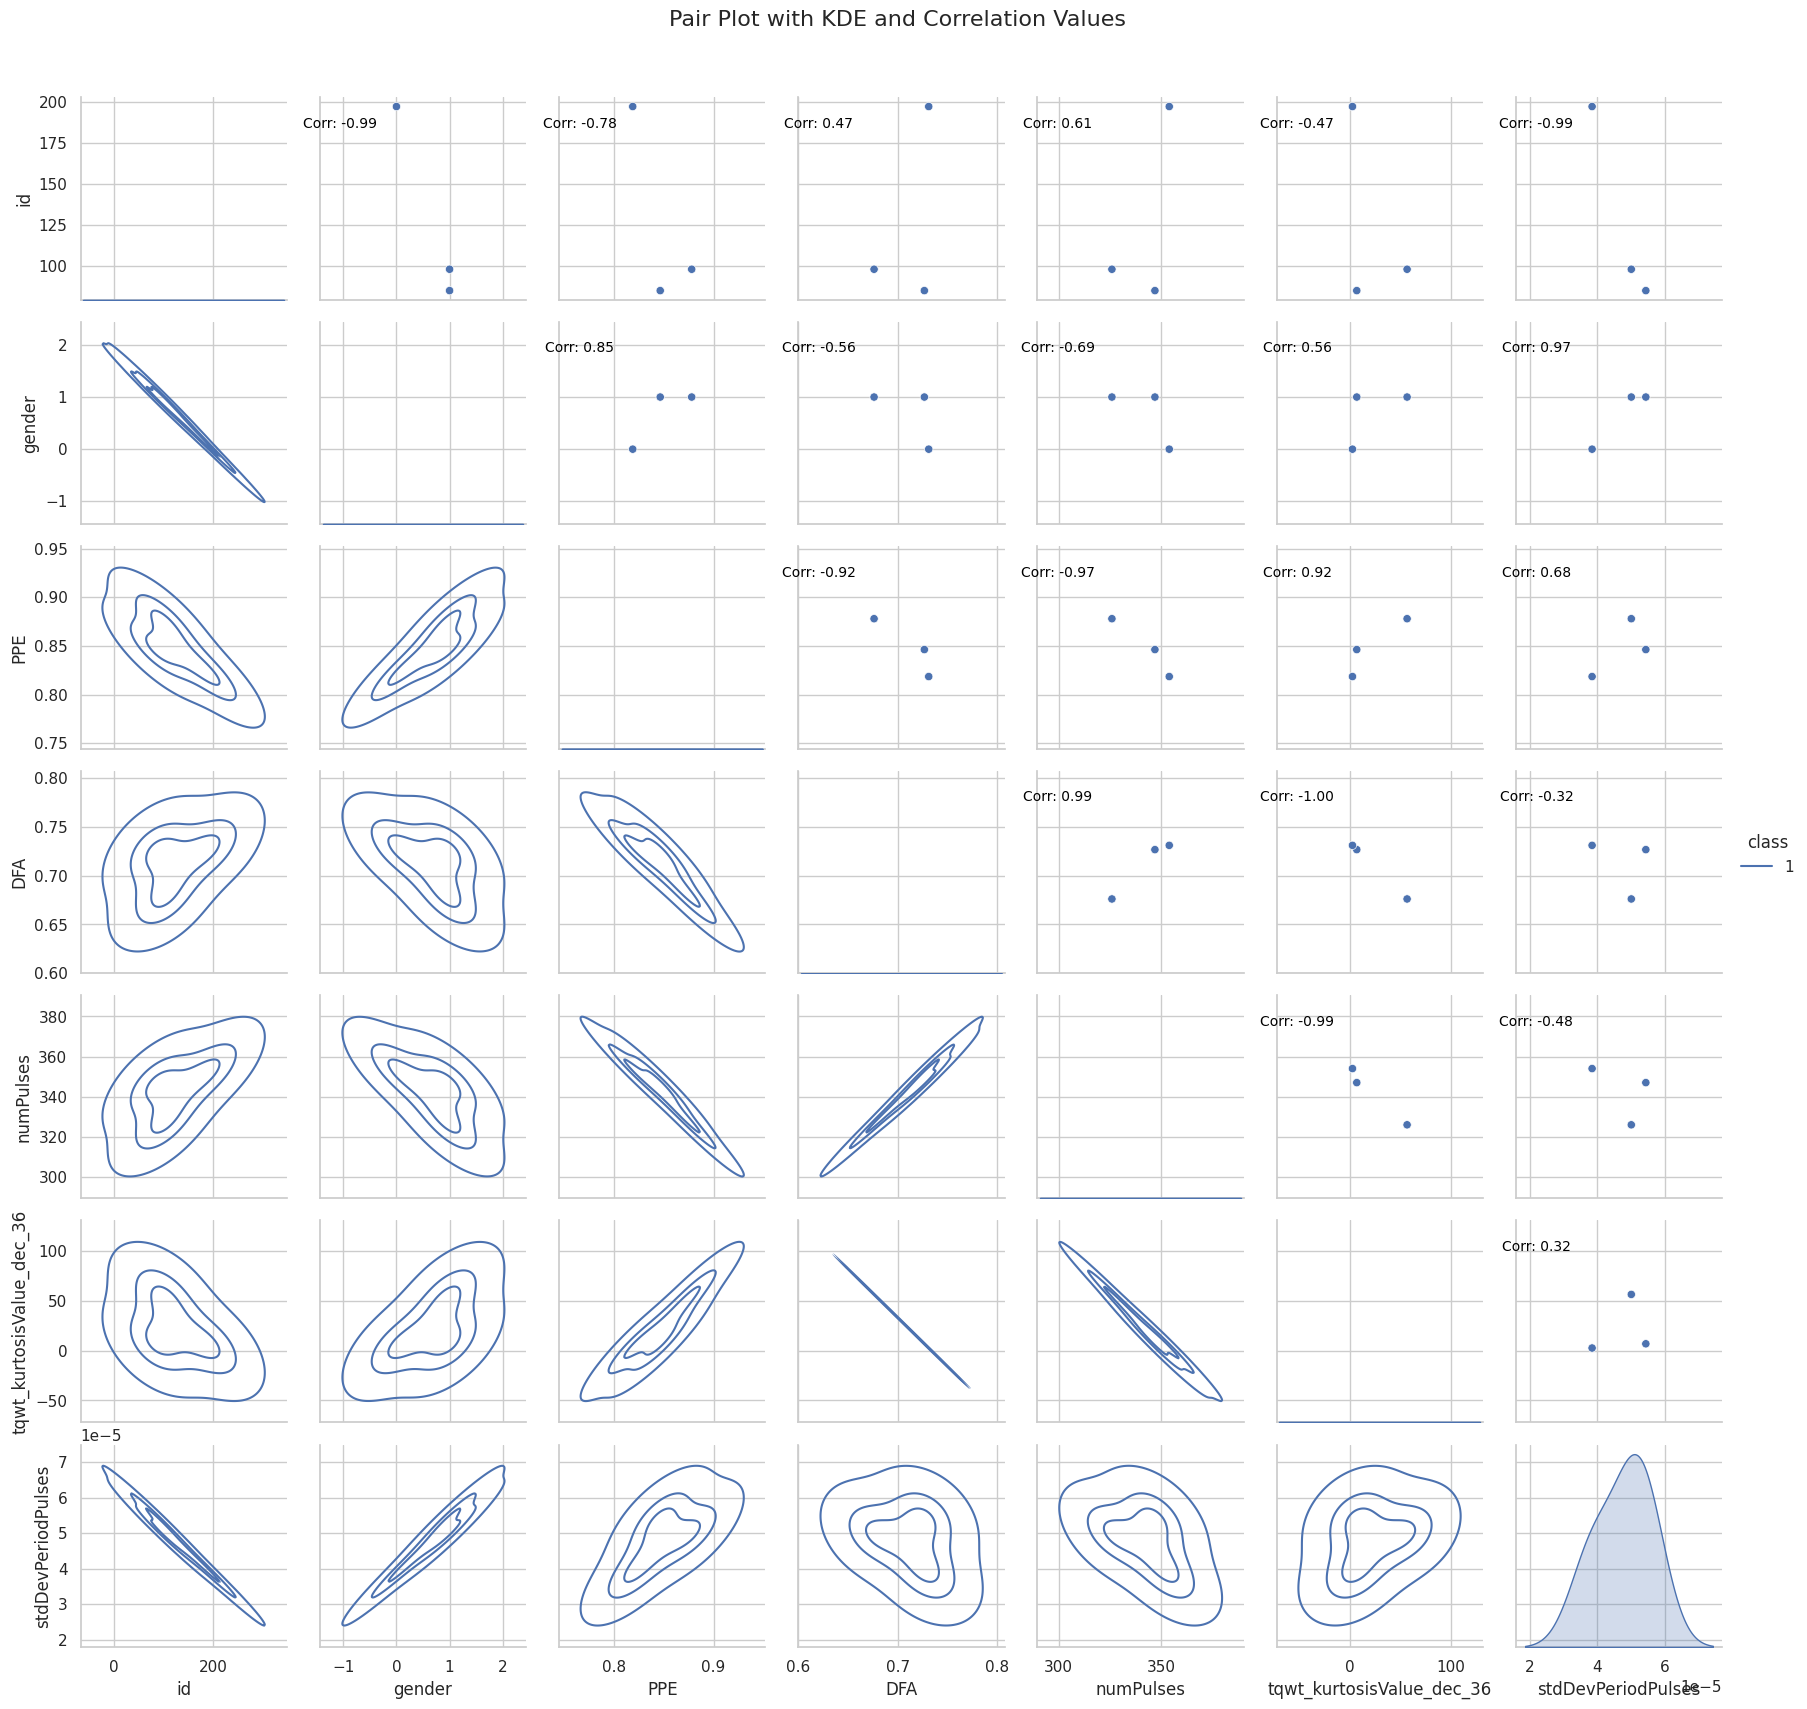

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


selected_features = data[['id','gender', 'PPE', 'DFA', 'numPulses', 'tqwt_kurtosisValue_dec_36', 'stdDevPeriodPulses', 'class']]


sns.set(style="whitegrid")
g = sns.PairGrid(selected_features, hue='class')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, shade=True)
g.map_lower(sns.kdeplot, levels=4, cmap="Blues_d")
g.add_legend()


corr_matrix = selected_features.corr()
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].annotate(f'Corr: {corr_matrix.iloc[i, j]:.2f}', (0.1, 0.85), xycoords='axes fraction', ha='center', fontsize=10, color='black')


g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Pair Plot with KDE and Correlation Values", fontsize=16)

plt.show()


FUNCTION FOR PLOTTING ACCURACY AND ROC

In [17]:
import matplotlib.pyplot as plt

def plot_Current_ROC(fpr, tpr, iterator, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'Fold {iterator + 1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
def average_ROC(mean_fpr, tprs, aucs_kNN):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs_kNN)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def average_performance(aucs_kNN, accuracy, TP, TN, FP, FN):
    mean_auc = np.mean(aucs_kNN)
    mean_accuracy = np.mean(accuracy)
    mean_TP = np.mean(TP)
    mean_TN = np.mean(TN)
    mean_FP = np.mean(FP)
    mean_FN = np.mean(FN)

    print(f'Mean AUC: {mean_auc:.2f}')
    print(f'Mean Accuracy: {mean_accuracy:.2f}')
    print(f'Mean True Positives: {mean_TP:.2f}')
    print(f'Mean True Negatives: {mean_TN:.2f}')
    print(f'Mean False Positives: {mean_FP:.2f}')

In [18]:
def metrics(y_true, y_pred, probas_):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    roc_auc = roc_auc_score(y_true, probas_[:, 1])

    fpr, tpr, _ = roc_curve(y_true, probas_[:, 1])

    return tn, fp, fn, tp, roc_auc, fpr, tpr

In [19]:
results = []

In [20]:
!pip install catboost

LOGISTIC REGRESSION

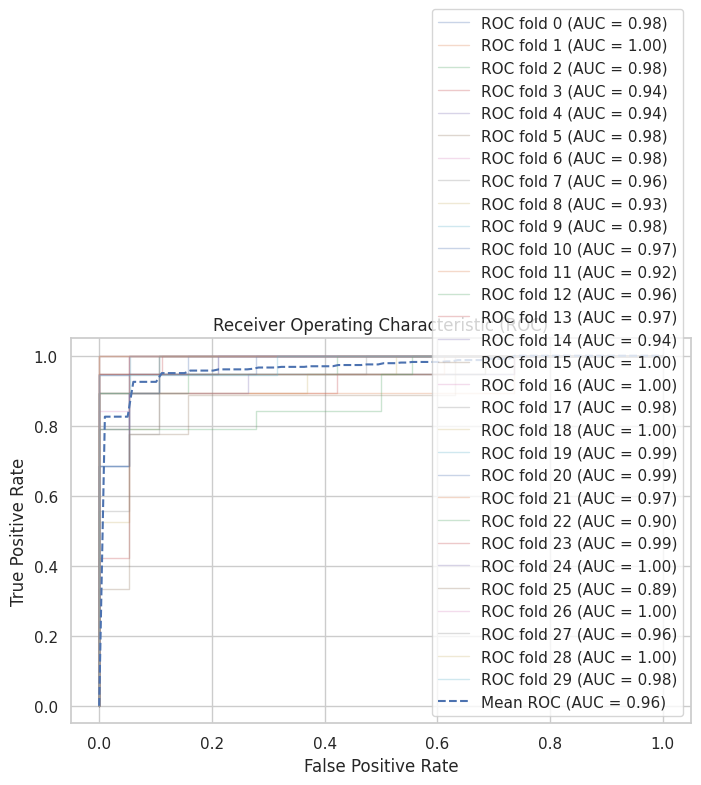

Accuracy (Avg. +/- Std.) is 0.928 +/- 0.046
Sensitivity (Avg. +/- Std.) is 0.882 +/- 0.095
Specificity (Avg. +/- Std.) is 0.975 +/- 0.033
Precision (Avg. +/- Std.) is 0.974 +/- 0.033
FOR (Avg. +/- Std.) is 0.102 +/- 0.074
DOR (Avg. +/- Std.) is inf +/- nan


In [21]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_logistic = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    logistic_params = {
        'max_iter': 100,
        'random_state': 69
    }

    clf = LogisticRegression(**logistic_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_logistic.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "LOGISTIC REGRESSION",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity": np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision": np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


K NEAREST NEIGHBOR

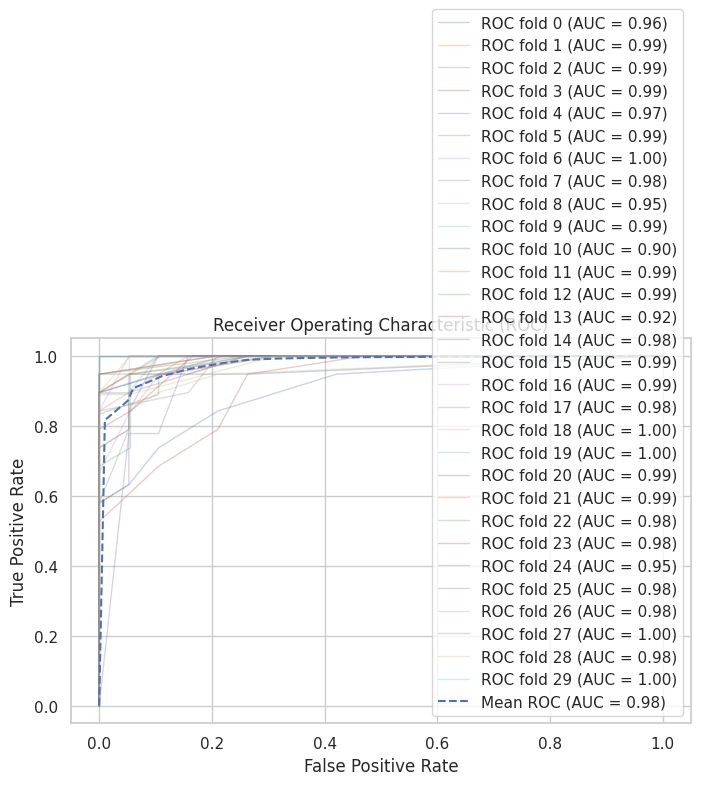

Accuracy (Avg. +/- Std.) is 0.924 +/- 0.045
Sensitivity (Avg. +/- Std.) is 0.891 +/- 0.067
Specificity (Avg. +/- Std.) is 0.958 +/- 0.052
Precision (Avg. +/- Std.) is 0.956 +/- 0.052
FOR (Avg. +/- Std.) is 0.100 +/- 0.059
DOR (Avg. +/- Std.) is inf +/- nan


In [22]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_knn = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    knn_params = {
        'n_neighbors': 5,
        'weights': 'uniform',
        'algorithm': 'auto'
    }

    clf = KNeighborsClassifier(**knn_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_knn.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "K-NEAREST NEIGHBORS",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity": np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision": np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


DECISION TREE

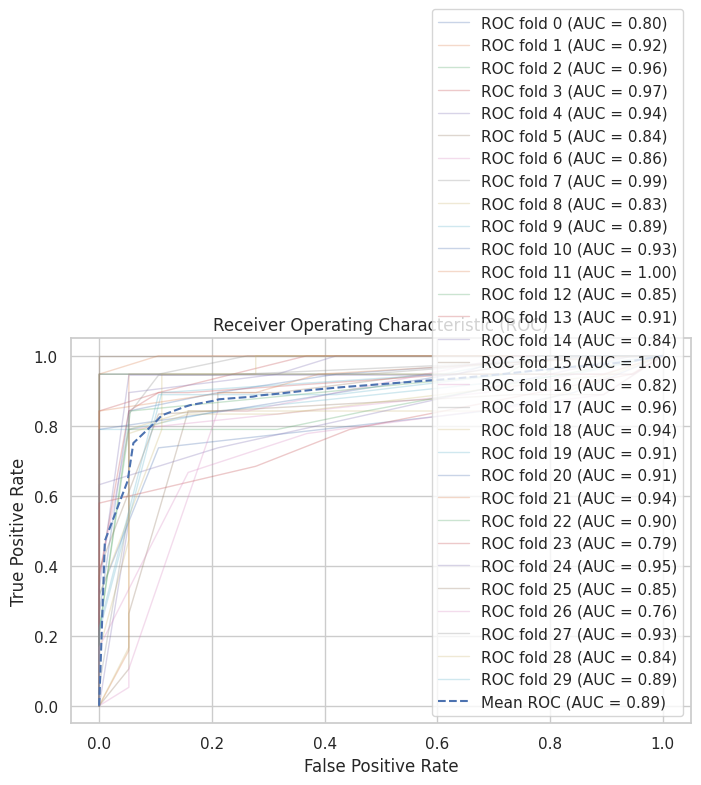

Accuracy (Avg. +/- Std.) is 0.888 +/- 0.062
Sensitivity (Avg. +/- Std.) is 0.840 +/- 0.102
Specificity (Avg. +/- Std.) is 0.936 +/- 0.066
Precision (Avg. +/- Std.) is 0.933 +/- 0.065
FOR (Avg. +/- Std.) is 0.140 +/- 0.075
DOR (Avg. +/- Std.) is inf +/- nan


In [23]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_decision_tree = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    decision_tree_params = {
        'criterion': 'gini',
        'max_depth': 5,
        'random_state': 69
    }

    clf = DecisionTreeClassifier(**decision_tree_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_decision_tree.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "DECISION TREE",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity": np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision": np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


CAT BOOSTING

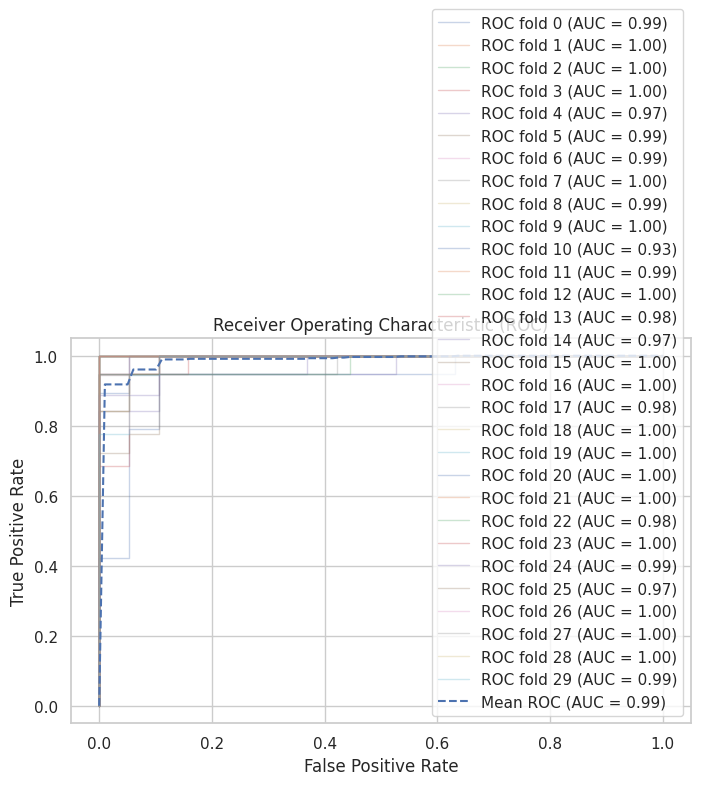

Accuracy (Avg. +/- Std.) is 0.949 +/- 0.039
Sensitivity (Avg. +/- Std.) is 0.935 +/- 0.063
Specificity (Avg. +/- Std.) is 0.963 +/- 0.047
Precision (Avg. +/- Std.) is 0.963 +/- 0.046
FOR (Avg. +/- Std.) is 0.061 +/- 0.055
DOR (Avg. +/- Std.) is inf +/- nan


In [24]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from catboost import CatBoostClassifier
n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_catboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    catboost_params = {
        'iterations': 90,
        'learning_rate': 0.05,
        'depth': 5,
        'l2_leaf_reg': 3,
        'loss_function': 'Logloss',
        'verbose': 0,
        'random_seed': 69
    }

    clf = CatBoostClassifier(**catboost_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_catboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "CATEGORICAL BOOSTING",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

XG BOOSTING

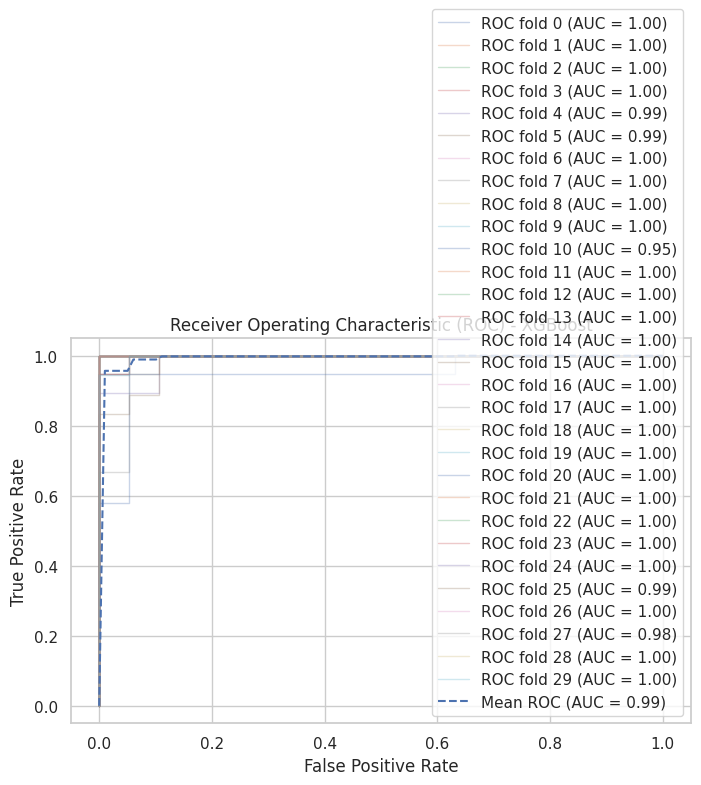

Accuracy (Avg. +/- Std.) is 0.971 +/- 0.027
Sensitivity (Avg. +/- Std.) is 0.967 +/- 0.040
Specificity (Avg. +/- Std.) is 0.975 +/- 0.038
Precision (Avg. +/- Std.) is 0.976 +/- 0.036
FOR (Avg. +/- Std.) is 0.032 +/- 0.038
DOR (Avg. +/- Std.) is inf +/- nan


In [25]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from xgboost import XGBClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_xgboost = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    xgboost_params = {
        'n_estimators': 250,
        'learning_rate': 0.09,
        'max_depth': 5,
        'subsample': 0.8,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 69
    }

    clf = XGBClassifier(**xgboost_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_xgboost.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "XG Boosting",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


RANDOM FOREST

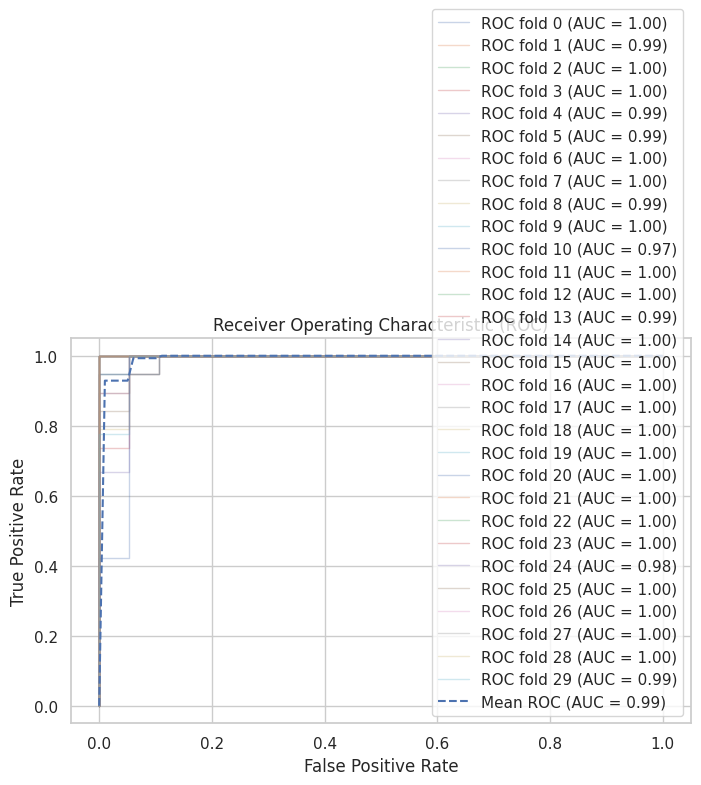

Accuracy (Avg. +/- Std.) is 0.963 +/- 0.030
Sensitivity (Avg. +/- Std.) is 0.952 +/- 0.050
Specificity (Avg. +/- Std.) is 0.974 +/- 0.040
Precision (Avg. +/- Std.) is 0.974 +/- 0.038
FOR (Avg. +/- Std.) is 0.044 +/- 0.045
DOR (Avg. +/- Std.) is inf +/- nan


In [26]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from sklearn.ensemble import RandomForestClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_rf = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    # Create and fit the Random Forest classifier with additional parameters
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=69)

    rf.fit(X_Train, Y_Train)

    y_pred_proba = rf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_rf.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "RANDOM FOREST",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})

Light GBM

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

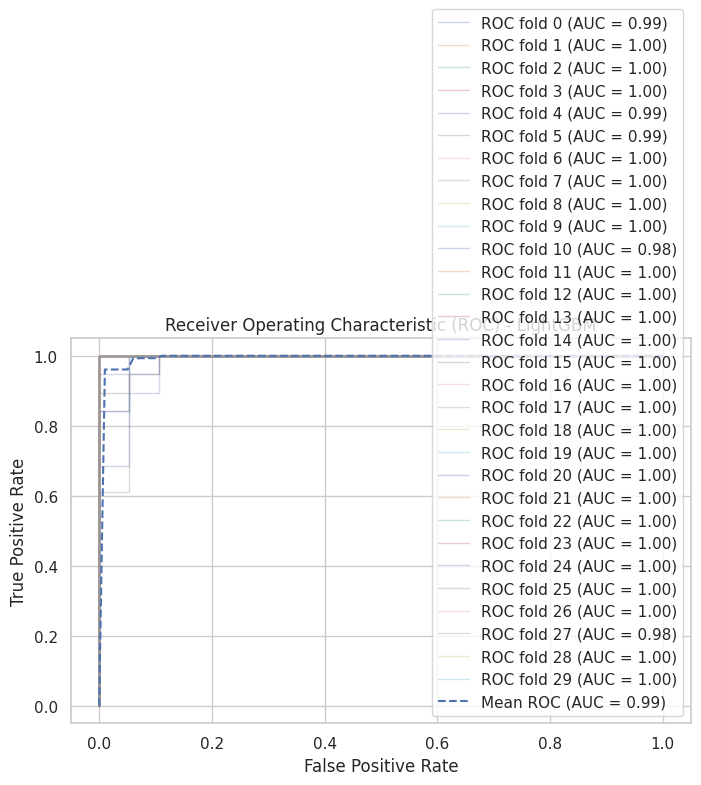

Accuracy (Avg. +/- Std.) is 0.975 +/- 0.028
Sensitivity (Avg. +/- Std.) is 0.974 +/- 0.038
Specificity (Avg. +/- Std.) is 0.977 +/- 0.038
Precision (Avg. +/- Std.) is 0.978 +/- 0.036
FOR (Avg. +/- Std.) is 0.025 +/- 0.036
DOR (Avg. +/- Std.) is inf +/- nan


In [28]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy import interp
from lightgbm import LGBMClassifier

n_splits = 30

Accuracy = []
FP = []
TN = []
FN = []
TP = []
tprs = []
aucs_lgb = []
sn = []
sp = []
pr = []
FOR = []
DOR = []
iterator = 0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)

for train_index, test_index in kf.split(X_Data, Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

    lgb_params = {
        'n_estimators': 250,
        'learning_rate': 0.09,
        'max_depth': 5,
        'subsample': 0.8,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'random_state': 69
    }

    clf = LGBMClassifier(**lgb_params)
    clf.fit(X_Train, Y_Train)

    y_pred_proba = clf.predict_proba(X_Test)[:, 1]

    tn, fp, fn, tp = metrics.confusion_matrix(Y_Test, (y_pred_proba > 0.5).astype(int)).ravel()
    fpr, tpr, _ = roc_curve(Y_Test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_lgb.append(roc_auc)

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    # Calculate and store accuracy
    accuracy = accuracy_score(Y_Test, (y_pred_proba > 0.5).astype(int))
    Accuracy.append(accuracy)

    sn.append(tp / (tp + fn))
    sp.append(tn / (fp + tn))
    pr.append(tp / (tp + fp))
    FOR.append(fn / (tn + fn))
    DOR.append((tp * tn) / (fp * fn))

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (iterator, roc_auc))

    iterator += 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', linestyle='--', label='Mean ROC (AUC = %0.2f)' % mean_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
plt.legend(loc='lower right')
plt.show()

print("Accuracy (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(Accuracy), np.std(Accuracy)))
print("Sensitivity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sn), np.std(sn)))
print("Specificity (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(sp), np.std(sp)))
print("Precision (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(pr), np.std(pr)))
print("FOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(FOR), np.std(FOR)))
print("DOR (Avg. +/- Std.) is %0.3f +/- %0.3f" % (np.mean(DOR), np.std(DOR)))

results.append({
        "Model Algorithm Name": "Light GBM",
        "Accuracy": np.mean(Accuracy),
        "Sensitivity":np.mean(sn),
        "Specificity": np.mean(sp),
        "Precision":np.mean(pr),
        "FOR": np.mean(FOR),
        "DOR": np.mean(DOR),
})


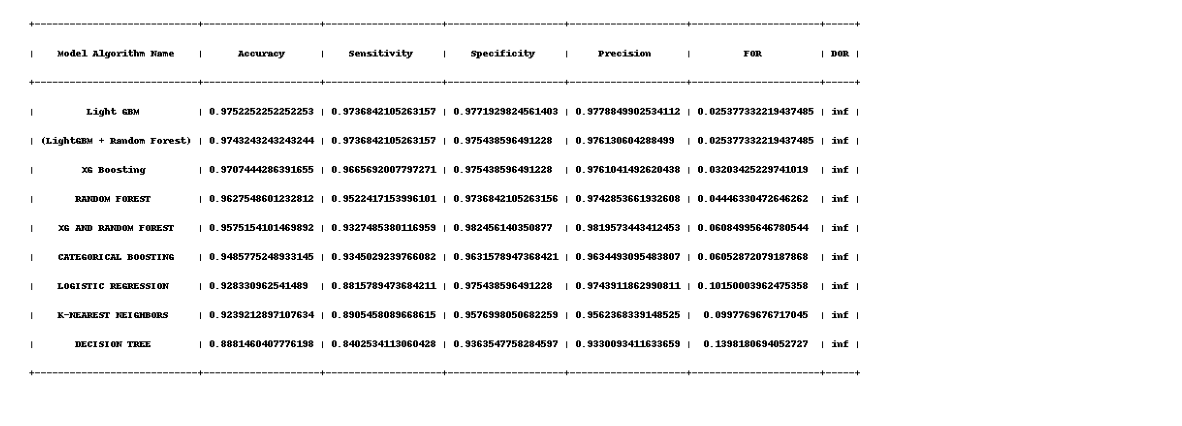

In [30]:
from prettytable import PrettyTable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Create a PrettyTable instance with column names
table = PrettyTable()
table.field_names = ["Model Algorithm Name", "Accuracy", "Sensitivity", "Specificity", "Precision", "FOR", "DOR"]

for result in results:
    sensitivity = result.get("Sensitivity", "N/A")
    specificity = result.get("Specificity", "N/A")
    precision = result.get("Precision", "N/A")
    for_ = result.get("FOR", "N/A")
    dor = result.get("DOR", "N/A")

    table.add_row([result["Model Algorithm Name"], result["Accuracy"], sensitivity, specificity, precision, for_, dor])

# Sort the table by accuracy in descending order
table.sortby = "Accuracy"
table.reversesort = True

# Get the table as a string
table_str = str(table)

# Split the table into rows
rows = table_str.split('\n')

# Set up the image
font_size = 14
line_height = 30
image_width = 1200  # Increase the image width
image_height = (len(rows) + 1) * line_height
image = Image.new("RGB", (image_width, image_height), "white")
draw = ImageDraw.Draw(image)

# Use a default system font
font = ImageFont.load_default()

# Define text positions
x_position = 20
y_position = 10

# Draw each row in the image
for row in rows:
    draw.text((x_position, y_position), row, fill="black", font=font)
    y_position += line_height

# Save the image with higher resolution
image.save("table_image.png", dpi=(300, 300))  # Set a higher DPI

# Display the image using Matplotlib
plt.figure(figsize=(15, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


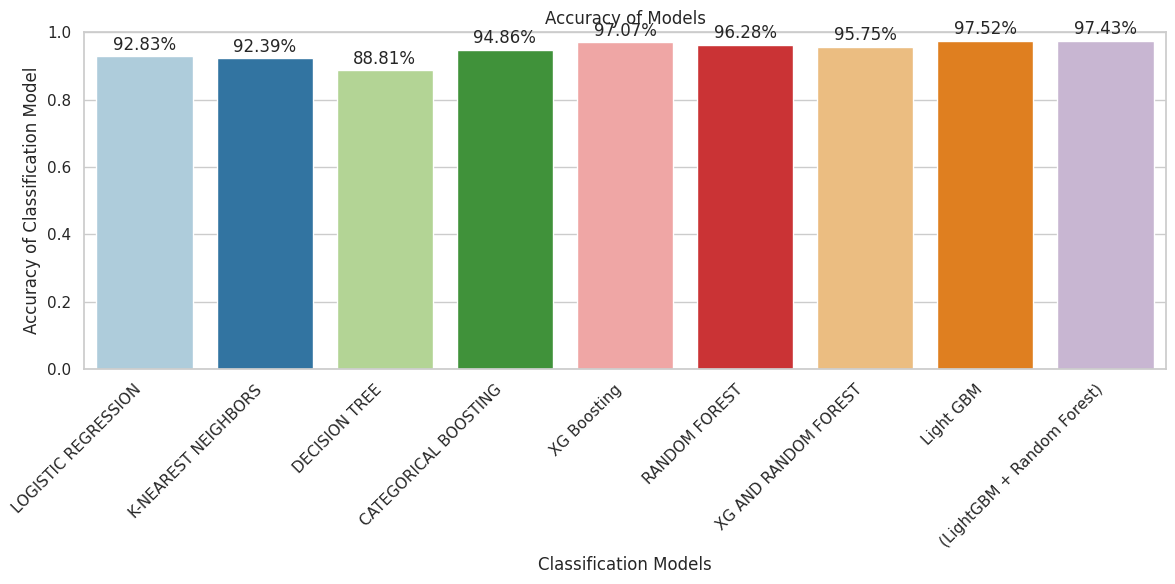

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract data for plotting
model_names = [result["Model Algorithm Name"] for result in results]
accuracy_values = [result["Accuracy"] for result in results]

# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Paired")

# Create a bar plot using Seaborn with rotated x-axis labels
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
ax = sns.barplot(x=model_names, y=accuracy_values)
plt.title("Accuracy of Models")
plt.xlabel('Classification Models')
plt.ylabel("Accuracy of Classification Model")
plt.ylim(0, 1)  # Set y-axis limit to be between 0 and 1

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Annotate each bar with its corresponding accuracy value
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.annotate(f'{round(height * 100, 2)}%', (x + width/2, y + height*1.02), ha='center')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
